Goal of this Notebook: Use graph search algorithms to solve Peg Solitaire: https://en.wikipedia.org/wiki/Peg_solitaire

In [165]:
%matplotlib inline

from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as plticker
import networkx as nx
import random
from collections import namedtuple
import heapq

In [166]:
class Problem():
    def __init__(self, problem_mapping):
        self._problem = problem_mapping
        self.states = self._problem.keys()
    
    def result(self, state, action):
        abstract
        
    def cost(self, action):
        abstract
        
    def available(self, state):
        assert state in self._problem
        return self._problem[state]
    
    def goal_test(self, state):
        abstract

In [167]:
class Node():
    def __init__(self, state, parent, action, path_cost):
        self.state = state
        self.parent = parent
        self.action = action
        self.path_cost = path_cost

In [168]:
def child_node(problem, parent, action):
    '''return a node that is a child of given node'''
    new_state = problem.result(parent.state, action)
    this_cost = parent.path_cost + problem.cost(action)
    return Node(new_state, parent, action, this_cost)

In [169]:
def breadth_first_search(problem, start_node):
    if problem.goal_test(start_node.state):
        return start_node
    frontier = [start_node]
    frontier_states = {start_node.state}
    explored = set([])
    while(1):
        if len(frontier) == 0:
            return 'FAILURE'
        this_node = frontier.pop(0)
        frontier_states.remove(this_node.state)
        explored.add(this_node.state)
        #print explored
        for action in problem.available(this_node.state):
            this_child = child_node(problem, this_node, action)
            if (this_child.state not in explored) and (this_child.state not in frontier_states):
                if problem.goal_test(this_child.state):
                    return this_child
                frontier.append(this_child)
                frontier_states.add(this_child.state)

In [170]:
def uniform_cost_search(problem, start_node):
    if problem.goal_test(start_node.state):
        return start_node

    frontier = []
    heapq.heappush(frontier, (0, start_node))
    
    frontier_states = {start_node.state:start_node.path_cost}
    explored = set([])
    
    while(1):
        try:
            this_node = heapq.heappop(frontier)[1]
        except IndexError:
            return 'FAILURE' #heap was empty
                
        del frontier_states[this_node.state]
        if problem.goal_test(this_node.state):
            print this_node
            return this_node
        explored.add(this_node.state)
        for action in problem.available(this_node.state):
            this_child = child_node(problem, this_node, action)
            if (this_child.state not in explored) and (this_child.state not in frontier_states.keys()):
                heapq.heappush(frontier, (this_child.path_cost, this_child))
                frontier_states[this_child.state] = this_child.path_cost
            elif (this_child.state in frontier_states.keys()):
                if frontier_states[this_child.state] > this_child.path_cost:
                    frontier_states[this_child.state] = this_child.path_cost
                    heapq.heappush(frontier, (this_child.path_cost, this_child))

In [171]:
def solution(node):
    if node == 'FAILURE':
        print node
    else:
        path = []
        this_node = node
        while(this_node is not None):
            path.append(this_node.state)
            this_node = this_node.parent
        path.reverse()
        print path

In [172]:
def recursive_dls(this_node, problem, limit):
    if problem.goal_test(this_node.state):
        return this_node
    if limit == 0:
        return 'CUTOFF'
    cutoffp = False
    for action in problem.available(this_node.state):
        this_child = child_node(problem, this_node, action)
        result = recursive_dls(this_child, problem, limit-1)
        if result == 'CUTOFF':
            cutoffp = True
        elif result != 'FAILURE':
            return result
    if cutoffp:
        return 'CUTOFF'
    else:
        return 'FAILURE'
    
def depth_limited_search(problem, limit, start_node):
    return recursive_dls(start_node, problem, limit)

In [173]:
def iterative_deepening_search(this_problem, start_node):
    depth = 0
    while(1):
        result = depth_limited_search(this_problem, depth, start_node)
        if result != 'CUTOFF':
            return result
        depth += 1

#Peg Solitaire

In [174]:
#Define a state as a mapping from (row, column) coordinates to boolean indicating presence of peg
#Define an action via the initial location and final locations of the moving peg

#What must we check to ensure a proposed move is valid?
# Start, end are on board
# Start, end are one jump apart
# Peg in start
# No peg in end
# Peg in between

In [175]:
#What is required to define the problem?

#A function that takes a state and returns available actions
#A function that takes a state and action and returns the resulting state
#A function that tests if the goal is reached

In [176]:
class Site():
    def __init__(self, index):
        self.index = index # Index of site
        self.neighbors = [] # List of sites that are nearest neighbors
        self.jumps = [] # List of potential jumps
        self.occupied = False
        
    @property
    def coords(self):
        '''Coordinates of geometric representation of site. For square lattice this is just indices'''
        return self.index
    
class TriSite(Site):
    @property
    def coords(self):
        '''Coordinates of geometric representation of site. Triangular lattice.'''
        xx, yy = self.index
        x_pt = -0.5 * (yy - 1) + xx
        return (x_pt, yy)
    
    def display(self):
        xx, yy = self.coords
        plt.plot(xx, yy, '*', color='yellow', markersize=10)
    
    def display_neighbors(self):
        for site in self.neighbors:
            if site is not None:
                xx, yy = site.coords
                plt.plot(xx, yy, 'o', color='green', markersize=10)
                
    def display_jumps(self):
        for jump in self.jumps:
            xx, yy = jump.end.coords
            plt.plot(xx, yy, 'o', color='blue', markersize=10)  
            

In [177]:
class Jump():
    def __init__(self, start, mid, end):
        self.start = start
        self.mid = mid
        self.end = end
        
    def describe(self):
        print 'Move peg in %s over %s into %s'%(self.start.index, self.mid.index, self.end.index)
     

In [178]:
   
class Board(object):
    def __init__(self):
        self.sites = [] # List of sites on the board
        self.indices = [] # List of valid indices
        self.index_map = {} # Mapping from indices to sites
        
    def display(self):
        exes = []
        wyes = []
        for site in self.sites:
            xx, yy = site.coords
            exes.append(xx)
            wyes.append(yy)
            if site.occupied:
                color = 'red'
            else:
                color = 'black'
            plt.plot(xx, yy, 'o', color=color, markersize=10)
        plt.xlim(0, max(exes)+1)
        plt.ylim(0, max(wyes)+1)
        
    def set_state(self, state):
        for entry in state:
            index, occupation = entry
            assert index in self.indices
            self.index_map[index].occupied = occupation
            
    @property
    def state(self):
        state = []
        for site in self.sites:
            site_state = (site.index, site.occupied)
            state.append(site_state)
        return tuple(state)
            
    @property
    def allowed_moves(self):
        moves = []
        start_sites = filter(lambda x: x.occupied, self.sites)
        for site in start_sites:
            allowed_jumps = filter(lambda x: x.mid.occupied and not x.end.occupied, site.jumps)
            moves.extend(allowed_jumps)
        return moves
    
    def list_moves(self):
        for move in self.allowed_moves:
            move.describe()
    
    def apply_move(self, jump):
        assert jump.start in self.sites
        assert jump.mid in self.sites
        assert jump.end in self.sites
        assert jump in jump.start.jumps
        assert jump.start.occupied
        assert not jump.end.occupied
        assert jump.mid.occupied
        
        jump.start.occupied = False
        jump.mid.occupied = False
        jump.end.occupied = True
    
    @property
    def score(self):
        return len(filter(lambda x: x.occupied, self.sites))
    
class TriBoard(Board):
    '''Board with Triangular Lattice'''
    def __init__(self, nrows):
        super(TriBoard, self).__init__()
        for ii in range(1, nrows+1):
            for jj in range(1, ii+1):
                this_site = TriSite((ii, jj))
                self.sites.append(this_site)
                self.indices.append((ii, jj))
                self.index_map.update({(ii,jj):this_site})

        for site in self.sites:
            ii, jj = site.index
            neighbor_indices = [(ii-1, jj), (ii, jj+1), (ii+1, jj+1), (ii+1, jj), (ii, jj-1), (ii-1, jj-1)]
            for index in neighbor_indices:
                if index in self.indices:
                    this_neighbor = self.index_map[index]
                    site.neighbors.append(this_neighbor)
                else:
                    site.neighbors.append(None)

        for site in self.sites:
            for ii in range(len(site.neighbors)):
                neighbor_ii = site.neighbors[ii]
                if neighbor_ii is not None:
                    nn_neighbor_ii = neighbor_ii.neighbors[ii]
                    if nn_neighbor_ii is not None:
                        this_jump = Jump(site, neighbor_ii, nn_neighbor_ii)
                        site.jumps.append(this_jump)
                        
        for site in self.sites:
            if site.index != (3,1):
                site.occupied = True
                
    def repopulate(self):
        for site in self.sites:
            if site.index != (3,1):
                site.occupied = True
            else:
                site.occupied = False
        
        
## Build a triangular board
this_board = TriBoard(7)

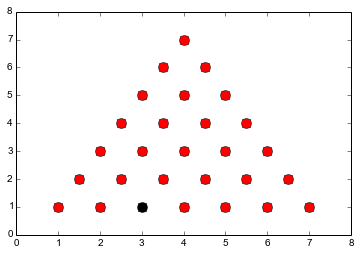

In [179]:
this_board.display()
#print this_board.sites[NN].index
#this_board.sites[NN].display()
#this_board.sites[NN].display_neighbors()
#this_board.sites[NN].display_jumps()

In [180]:
this_board.list_moves()

Move peg in (1, 1) over (2, 1) into (3, 1)
Move peg in (3, 3) over (3, 2) into (3, 1)
Move peg in (5, 1) over (4, 1) into (3, 1)
Move peg in (5, 3) over (4, 2) into (3, 1)


In [181]:
print this_board.state

(((1, 1), True), ((2, 1), True), ((2, 2), True), ((3, 1), False), ((3, 2), True), ((3, 3), True), ((4, 1), True), ((4, 2), True), ((4, 3), True), ((4, 4), True), ((5, 1), True), ((5, 2), True), ((5, 3), True), ((5, 4), True), ((5, 5), True), ((6, 1), True), ((6, 2), True), ((6, 3), True), ((6, 4), True), ((6, 5), True), ((6, 6), True), ((7, 1), True), ((7, 2), True), ((7, 3), True), ((7, 4), True), ((7, 5), True), ((7, 6), True), ((7, 7), True))


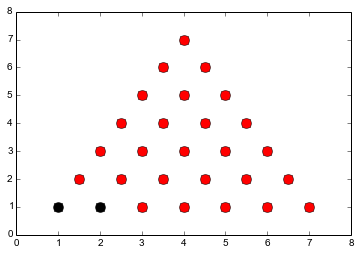

In [182]:
first_move = this_board.allowed_moves[0]
this_board.apply_move(first_move)
this_board.display()

In [183]:
this_board.list_moves()

Move peg in (3, 3) over (2, 2) into (1, 1)
Move peg in (4, 1) over (3, 1) into (2, 1)
Move peg in (4, 3) over (3, 2) into (2, 1)


(array([   9.,   22.,   92.,  144.,    0.,  102.,   24.,    2.,    3.,    2.]),
 array([ 1. ,  1.8,  2.6,  3.4,  4.2,  5. ,  5.8,  6.6,  7.4,  8.2,  9. ]),
 <a list of 10 Patch objects>)

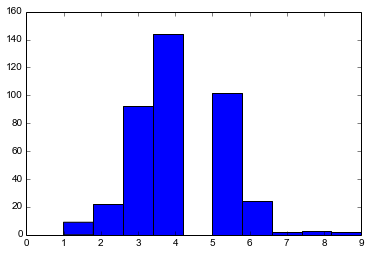

In [184]:
## Get some idea of the performance of a random solver

numruns = 400
final_scores = []

for ii in range(numruns):
    this_board = TriBoard(6)
    while len(this_board.allowed_moves) > 0:
        this_move = np.random.choice(this_board.allowed_moves)
        #this_move.describe()
        this_board.apply_move(this_move)
        #this_board.display()
    final_scores.append(this_board.score)
plt.hist(final_scores)

In [185]:
print np.min(final_scores)
print "\nsuccess rate:"
print float(len(filter(lambda x: x == 1, final_scores))) / numruns

1

success rate:
0.0225


In [186]:
# Question I don't know how to answer: What is the distribution of final scores when moves are at random?

#Set up Peg Solitaire for graph search

In [187]:
class PegSolitaire(Problem):
    def __init__(self, board):
        self.board = board
    
    def result(self, state, action):
        self.board.set_state(state)
        assert action in self.board.allowed_moves
        self.board.apply_move(action)
        return self.board.state
        
        
    def cost(self, action):
        return 1
        
    def available(self, state):
        self.board.set_state(state)
        return self.board.allowed_moves
    
    def goal_test(self, state):
        score = len(filter(lambda x: x, [ss[1] for ss in state]))
        return score == 1

In [188]:
this_board = TriBoard(5)
this_start_state = this_board.state
this_start_node = Node(this_start_state, None, None, 0)
this_solitaire = PegSolitaire(this_board)

In [189]:
print this_board.state
print this_start_state
print this_start_node.state

(((1, 1), True), ((2, 1), True), ((2, 2), True), ((3, 1), False), ((3, 2), True), ((3, 3), True), ((4, 1), True), ((4, 2), True), ((4, 3), True), ((4, 4), True), ((5, 1), True), ((5, 2), True), ((5, 3), True), ((5, 4), True), ((5, 5), True))
(((1, 1), True), ((2, 1), True), ((2, 2), True), ((3, 1), False), ((3, 2), True), ((3, 3), True), ((4, 1), True), ((4, 2), True), ((4, 3), True), ((4, 4), True), ((5, 1), True), ((5, 2), True), ((5, 3), True), ((5, 4), True), ((5, 5), True))
(((1, 1), True), ((2, 1), True), ((2, 2), True), ((3, 1), False), ((3, 2), True), ((3, 3), True), ((4, 1), True), ((4, 2), True), ((4, 3), True), ((4, 4), True), ((5, 1), True), ((5, 2), True), ((5, 3), True), ((5, 4), True), ((5, 5), True))


In [190]:
def solution_ps(node):
    if node == 'FAILURE':
        print node
    else:
        path = []
        this_node = node
        while(this_node is not None):
            path.append(this_node.action)
            this_node = this_node.parent
        path.reverse()
        return path[1:]
    
def describe_solution(node):
    path = solution_ps(node)
    for jump in path:
        jump.describe()

In [191]:
peg_solution = breadth_first_search(this_solitaire, this_start_node)

In [192]:
print solution_ps(peg_solution)

[<__main__.Jump instance at 0x7f648c55a2d8>, <__main__.Jump instance at 0x7f648c4a80e0>, <__main__.Jump instance at 0x7f648c55a878>, <__main__.Jump instance at 0x7f648c4a87e8>, <__main__.Jump instance at 0x7f648c55a758>, <__main__.Jump instance at 0x7f648c4a8f38>, <__main__.Jump instance at 0x7f648c4a8320>, <__main__.Jump instance at 0x7f648c4a8e18>, <__main__.Jump instance at 0x7f648c4a8098>, <__main__.Jump instance at 0x7f648c4a8d40>, <__main__.Jump instance at 0x7f648c55ac68>, <__main__.Jump instance at 0x7f648c55ad40>, <__main__.Jump instance at 0x7f648c4a86c8>]


In [193]:
describe_solution(peg_solution)

Move peg in (1, 1) over (2, 1) into (3, 1)
Move peg in (3, 3) over (2, 2) into (1, 1)
Move peg in (3, 1) over (3, 2) into (3, 3)
Move peg in (4, 4) over (3, 3) into (2, 2)
Move peg in (1, 1) over (2, 2) into (3, 3)
Move peg in (5, 3) over (4, 2) into (3, 1)
Move peg in (4, 1) over (3, 1) into (2, 1)
Move peg in (5, 5) over (5, 4) into (5, 3)
Move peg in (5, 2) over (5, 3) into (5, 4)
Move peg in (5, 4) over (4, 3) into (3, 2)
Move peg in (3, 3) over (3, 2) into (3, 1)
Move peg in (2, 1) over (3, 1) into (4, 1)
Move peg in (5, 1) over (4, 1) into (3, 1)


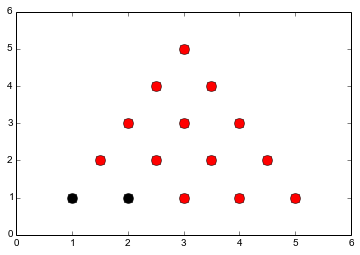

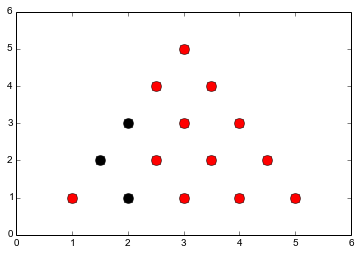

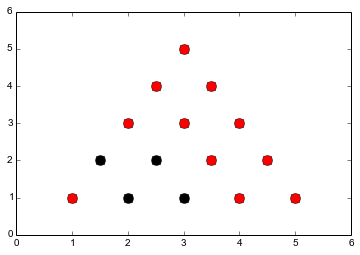

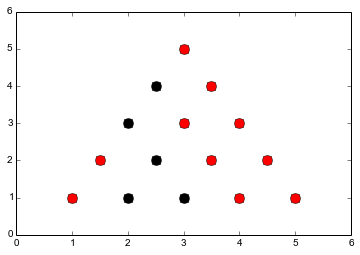

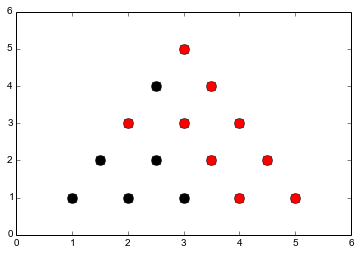

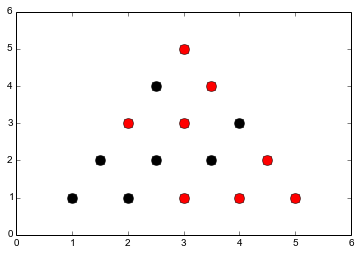

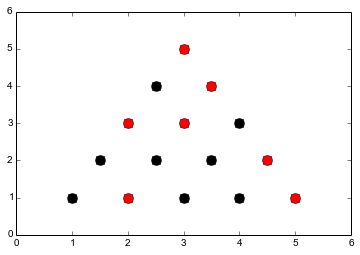

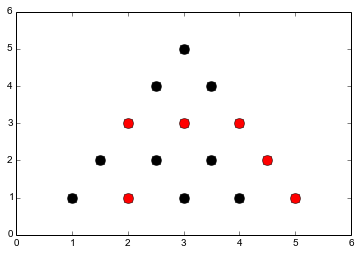

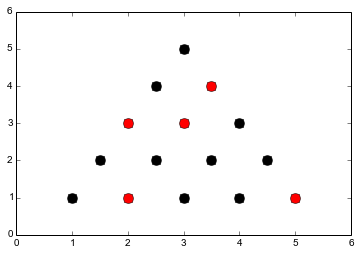

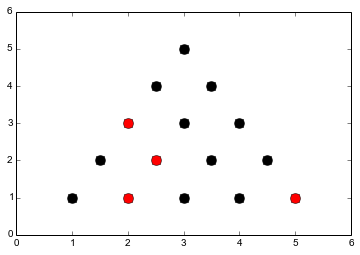

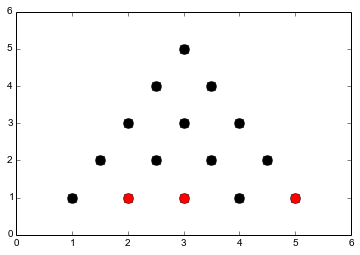

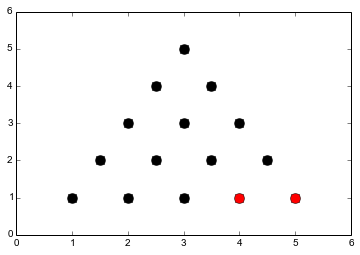

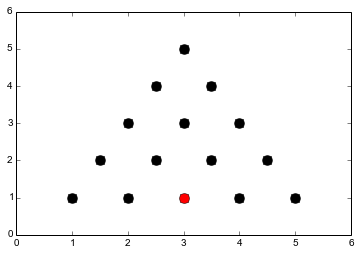

In [194]:
this_board.repopulate()
for jump in solution_ps(peg_solution):
    #jump.describe()
    this_board.apply_move(jump)
    plt.figure()
    this_board.display()